# LSTM for Time series prediction

What LSTM solves: Given the last few `n` samples of data in time, predict the next few `m` samples of data.

See https://colah.github.io/posts/2015-08-Understanding-LSTMs/ for more information about LSTMs. 

## Updates

* Data is now normalized in `[-.5, .5]`. Turns out tanh performs best if data is normalized. As a result the model has a much lower MSE.
* For consistency with the other models, add "time of the day" (minute offset, 0-1440) as an input feature.

## Prelude

Import all the packages.

In [52]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import collections
import math

# Part A. Data processing

## Import dataset

Import dataset into a pandas DataFrame.

`dataset.csv` is the Birmingham carpark dataset and should exist in the jupyter notebook directory.
Get it from https://archive.ics.uci.edu/ml/datasets/Parking+Birmingham

In [53]:
def import_dataset():
    with open('dataset.csv', 'r') as f:
        x = f.read().strip().split('\n')
    y = [x.split(',') for x in x]
    y = y[1:]  # First line is header
    SystemCodeNumber, Capacity, Occupancy, LastUpdated = zip(*y)
    Capacity = pd.to_numeric(Capacity)
    Occupancy = pd.to_numeric(Occupancy)
    LastUpdated = pd.to_datetime(LastUpdated)
    return pd.DataFrame({'SystemCodeNumber': SystemCodeNumber, 'Capacity': Capacity, 'Occupancy': Occupancy}, index=LastUpdated)

ds_import = import_dataset()
ds_import

,Capacity,Occupancy,SystemCodeNumber
2016-10-04 07:59:42,577,61,BHMBCCMKT01
2016-10-04 08:25:42,577,64,BHMBCCMKT01
2016-10-04 08:59:42,577,80,BHMBCCMKT01
2016-10-04 09:32:46,577,107,BHMBCCMKT01
2016-10-04 09:59:48,577,150,BHMBCCMKT01
2016-10-04 10:26:49,577,177,BHMBCCMKT01
2016-10-04 10:59:48,577,219,BHMBCCMKT01
2016-10-04 11:25:47,577,247,BHMBCCMKT01
2016-10-04 11:59:44,577,259,BHMBCCMKT01
2016-10-04 12:29:45,577,266,BHMBCCMKT01


## Split dataset into different carparks

At the same time, determine their capacity.

In [54]:
def split_into_carparks(dataset):
    "Output: { carpark_name: (dataset, capacity) }"
    carparks = dataset['SystemCodeNumber'].unique()
    out = {}
    for carpark in carparks:
        x = dataset.loc[dataset['SystemCodeNumber'] == carpark]
        capacity = x['Capacity'].iloc[0]
        assert x[x['Capacity'] != capacity].shape[0] == 0, 'Capacity is not the same for all rows!'
        out[carpark] = x['Occupancy'], capacity
    return out

ds_split = split_into_carparks(ds_import)
ds_split

{'BHMBCCMKT01': (2016-10-04 07:59:42     61
  2016-10-04 08:25:42     64
  2016-10-04 08:59:42     80
  2016-10-04 09:32:46    107
  2016-10-04 09:59:48    150
  2016-10-04 10:26:49    177
  2016-10-04 10:59:48    219
  2016-10-04 11:25:47    247
  2016-10-04 11:59:44    259
  2016-10-04 12:29:45    266
  2016-10-04 13:02:48    269
  2016-10-04 13:29:45    263
  2016-10-04 14:02:47    238
  2016-10-04 14:29:49    215
  2016-10-04 14:57:13    192
  2016-10-04 15:30:14    165
  2016-10-04 16:04:12    162
  2016-10-04 16:31:14    143
  2016-10-05 07:57:17     54
  2016-10-05 08:30:15     59
  2016-10-05 09:04:19     71
  2016-10-05 09:30:15     83
  2016-10-05 10:04:15    114
  2016-10-05 10:30:17    128
  2016-10-05 11:04:19    148
  2016-10-05 11:30:18    162
  2016-10-05 12:04:14    178
  2016-10-05 12:30:16    183
  2016-10-05 12:57:15    175
  2016-10-05 13:30:19    179
                        ... 
  2016-12-18 11:03:25     89
  2016-12-18 11:30:22    135
  2016-12-18 12:03:23    165

## Resample data

The Birmingham carpark dataset is updated every 30min from 8am to 5pm. However, the dataset doesn't actually contain samples at exactly 30min intervals. (e.g. first sample is taken at `2016-10-04 07:59:42`, and second sample is taken at `2016-10-04 07:59:42`). Furthermore, data is sometimes entirely missing for certain times.

We want the timings for each sample to be precisely at 8am, 8.30am, 9am, 9.30am etc. To do that we first upsample the dataset to 1min interval, then interpolate over missing data, and then downsample it down to 30min intervals. Set limit to 60 because we don't want to over-interpolate and fill in up to 1hr worth of junk data.

In [55]:
def resample_data(dataset):
    out = {}
    for k, (v, capacity) in dataset.items():
        out[k] = v.resample('1T').mean().interpolate(method='time',limit_direction='both', limit=60).resample('30T').mean().astype(np.float32), capacity
    return out

ds_resample = resample_data(ds_split)
ds_resample

{'BHMBCCMKT01': (2016-10-04 07:30:00     61.000000
  2016-10-04 08:00:00     62.906864
  2016-10-04 08:30:00     73.176468
  2016-10-04 09:00:00     92.681816
  2016-10-04 09:30:00    126.984848
  2016-10-04 10:00:00    165.554550
  2016-10-04 10:30:00    200.545456
  2016-10-04 11:00:00    235.450974
  2016-10-04 11:30:00    253.882355
  2016-10-04 12:00:00    262.616669
  2016-10-04 12:30:00    267.409088
  2016-10-04 13:00:00    266.190918
  2016-10-04 13:30:00    251.257568
  2016-10-04 14:00:00    227.342422
  2016-10-04 14:30:00    202.268188
  2016-10-04 15:00:00    177.681824
  2016-10-04 15:30:00    163.720581
  2016-10-04 16:00:00    154.405960
  2016-10-04 16:30:00    141.722733
  2016-10-04 17:00:00    138.819107
  2016-10-04 17:30:00    137.281311
  2016-10-04 18:00:00           NaN
  2016-10-04 18:30:00           NaN
  2016-10-04 19:00:00           NaN
  2016-10-04 19:30:00           NaN
  2016-10-04 20:00:00           NaN
  2016-10-04 20:30:00           NaN
  2016-10-04 

## Which carparks are missing too much data?

Some carparks are missing too much data to be usable.
Find out what they are by counting what percentage of their data between 8am to 5pm are `NaN`s.

In [56]:
def get_missing_data_percent(dataset):
    out = []
    for (k, (v, capacity)) in dataset.items():
        x = v.between_time('08:00', '17:00')
        out.append((x[x.isnull()].shape[0] / float(x.shape[0]) * 100, k))
    return out

print('\n'.join(repr(x) for x in sorted(get_missing_data_percent(ds_resample))))

(5.266757865937072, 'BHMBCCMKT01')
(5.266757865937072, 'BHMBCCTHL01')
(5.266757865937072, 'BHMEURBRD01')
(5.266757865937072, 'BHMMBMMBX01')
(5.266757865937072, 'BHMNCPNST01')
(5.266757865937072, 'Broad Street')
(5.266757865937072, 'Others-CCCPS105a')
(5.266757865937072, 'Others-CCCPS119a')
(5.266757865937072, 'Others-CCCPS135a')
(5.266757865937072, 'Others-CCCPS202')
(5.266757865937072, 'Others-CCCPS8')
(5.266757865937072, 'Others-CCCPS98')
(5.266757865937072, 'Shopping')
(5.403556771545827, 'BHMNCPHST01')
(6.566347469220246, 'BHMBCCSNH01')
(6.566347469220246, 'BHMNCPLDH01')
(6.566347469220246, 'Others-CCCPS133')
(6.6347469220246245, 'BHMNCPPLS01')
(7.865937072503421, 'BHMBCCPST01')
(7.865937072503421, 'BHMEURBRD02')
(9.537366548042705, 'NIA Car Parks')
(9.537366548042705, 'NIA South')
(14.36388508891929, 'BHMBRCBRG01')
(14.36388508891929, 'BHMBRCBRG02')
(14.36388508891929, 'BHMBRCBRG03')
(14.36388508891929, 'Bull Ring')
(14.432284541723666, 'BHMNCPRAN01')
(16.8141592920354, 'BHMBRTARC

## Remove carparks missing too much data

For (hopefully) good results, we remove carparks that have above 6% NANs.

In [57]:
def remove_bad_datasets(dataset, crit=6):
    out = {}
    for p, k in get_missing_data_percent(dataset):
        if p >= crit:
            continue
        out[k] = dataset[k]
    return out

ds_badrm = remove_bad_datasets(ds_resample)
ds_badrm

{'BHMBCCMKT01': (2016-10-04 07:30:00     61.000000
  2016-10-04 08:00:00     62.906864
  2016-10-04 08:30:00     73.176468
  2016-10-04 09:00:00     92.681816
  2016-10-04 09:30:00    126.984848
  2016-10-04 10:00:00    165.554550
  2016-10-04 10:30:00    200.545456
  2016-10-04 11:00:00    235.450974
  2016-10-04 11:30:00    253.882355
  2016-10-04 12:00:00    262.616669
  2016-10-04 12:30:00    267.409088
  2016-10-04 13:00:00    266.190918
  2016-10-04 13:30:00    251.257568
  2016-10-04 14:00:00    227.342422
  2016-10-04 14:30:00    202.268188
  2016-10-04 15:00:00    177.681824
  2016-10-04 15:30:00    163.720581
  2016-10-04 16:00:00    154.405960
  2016-10-04 16:30:00    141.722733
  2016-10-04 17:00:00    138.819107
  2016-10-04 17:30:00    137.281311
  2016-10-04 18:00:00           NaN
  2016-10-04 18:30:00           NaN
  2016-10-04 19:00:00           NaN
  2016-10-04 19:30:00           NaN
  2016-10-04 20:00:00           NaN
  2016-10-04 20:30:00           NaN
  2016-10-04 

## Finally fill in all missing data

Finally, use interpolation to fill in all missing data.
This includes the timings for which data does not simply exist (5pm to 8am).

In [58]:
def fill_in_missing_data(dataset):
    out = {}
    for k, (v, capacity) in dataset.items():
        out[k] = v.interpolate(method='linear'), capacity
    return out

ds_filled = fill_in_missing_data(ds_badrm)
dataset = ds_filled
ds_filled

{'BHMBCCMKT01': (2016-10-04 07:30:00     61.000000
  2016-10-04 08:00:00     62.906864
  2016-10-04 08:30:00     73.176468
  2016-10-04 09:00:00     92.681816
  2016-10-04 09:30:00    126.984848
  2016-10-04 10:00:00    165.554550
  2016-10-04 10:30:00    200.545456
  2016-10-04 11:00:00    235.450974
  2016-10-04 11:30:00    253.882355
  2016-10-04 12:00:00    262.616669
  2016-10-04 12:30:00    267.409088
  2016-10-04 13:00:00    266.190918
  2016-10-04 13:30:00    251.257568
  2016-10-04 14:00:00    227.342422
  2016-10-04 14:30:00    202.268188
  2016-10-04 15:00:00    177.681824
  2016-10-04 15:30:00    163.720581
  2016-10-04 16:00:00    154.405960
  2016-10-04 16:30:00    141.722733
  2016-10-04 17:00:00    138.819107
  2016-10-04 17:30:00    137.281311
  2016-10-04 18:00:00    134.296280
  2016-10-04 18:30:00    131.311264
  2016-10-04 19:00:00    128.326233
  2016-10-04 19:30:00    125.341209
  2016-10-04 20:00:00    122.356178
  2016-10-04 20:30:00    119.371155
  2016-10-04 

## Normalize data to [-.5, .5]

This is needed for the LSTM model to perform well.

In [59]:
def rescale(dataset):
    out = {}
    for k, (v, capacity) in dataset.items():
        out[k] = (v / float(capacity)) - 0.5, capacity
    return out

ds_rescale = rescale(ds_filled)
dataset = ds_rescale
ds_rescale

{'BHMBCCMKT01': (2016-10-04 07:30:00   -0.394281
  2016-10-04 08:00:00   -0.390976
  2016-10-04 08:30:00   -0.373178
  2016-10-04 09:00:00   -0.339373
  2016-10-04 09:30:00   -0.279922
  2016-10-04 10:00:00   -0.213077
  2016-10-04 10:30:00   -0.152434
  2016-10-04 11:00:00   -0.091939
  2016-10-04 11:30:00   -0.059996
  2016-10-04 12:00:00   -0.044858
  2016-10-04 12:30:00   -0.036553
  2016-10-04 13:00:00   -0.038664
  2016-10-04 13:30:00   -0.064545
  2016-10-04 14:00:00   -0.105992
  2016-10-04 14:30:00   -0.149449
  2016-10-04 15:00:00   -0.192059
  2016-10-04 15:30:00   -0.216255
  2016-10-04 16:00:00   -0.232399
  2016-10-04 16:30:00   -0.254380
  2016-10-04 17:00:00   -0.259412
  2016-10-04 17:30:00   -0.262077
  2016-10-04 18:00:00   -0.267251
  2016-10-04 18:30:00   -0.272424
  2016-10-04 19:00:00   -0.277598
  2016-10-04 19:30:00   -0.282771
  2016-10-04 20:00:00   -0.287944
  2016-10-04 20:30:00   -0.293118
  2016-10-04 21:00:00   -0.298291
  2016-10-04 21:30:00   -0.303464

In [60]:
def add_min_of_day(dataset):
    out = {}
    for k, (v, capacity) in dataset.items():
        out[k] = v.to_frame('Occupancy').assign(MinOfDay=((v.index.hour * 60 + v.index.minute) / (24.0 * 60)) - 0.5), capacity
    return out

ds_minofday = add_min_of_day(ds_rescale)
dataset = ds_minofday
ds_minofday

{'BHMBCCMKT01': (                     Occupancy  MinOfDay
  2016-10-04 07:30:00  -0.394281 -0.187500
  2016-10-04 08:00:00  -0.390976 -0.166667
  2016-10-04 08:30:00  -0.373178 -0.145833
  2016-10-04 09:00:00  -0.339373 -0.125000
  2016-10-04 09:30:00  -0.279922 -0.104167
  2016-10-04 10:00:00  -0.213077 -0.083333
  2016-10-04 10:30:00  -0.152434 -0.062500
  2016-10-04 11:00:00  -0.091939 -0.041667
  2016-10-04 11:30:00  -0.059996 -0.020833
  2016-10-04 12:00:00  -0.044858  0.000000
  2016-10-04 12:30:00  -0.036553  0.020833
  2016-10-04 13:00:00  -0.038664  0.041667
  2016-10-04 13:30:00  -0.064545  0.062500
  2016-10-04 14:00:00  -0.105992  0.083333
  2016-10-04 14:30:00  -0.149449  0.104167
  2016-10-04 15:00:00  -0.192059  0.125000
  2016-10-04 15:30:00  -0.216255  0.145833
  2016-10-04 16:00:00  -0.232399  0.166667
  2016-10-04 16:30:00  -0.254380  0.187500
  2016-10-04 17:00:00  -0.259412  0.208333
  2016-10-04 17:30:00  -0.262077  0.229167
  2016-10-04 18:00:00  -0.267251  0.250

## Plot the data

Finally, plot the data to get a sense of all the data.

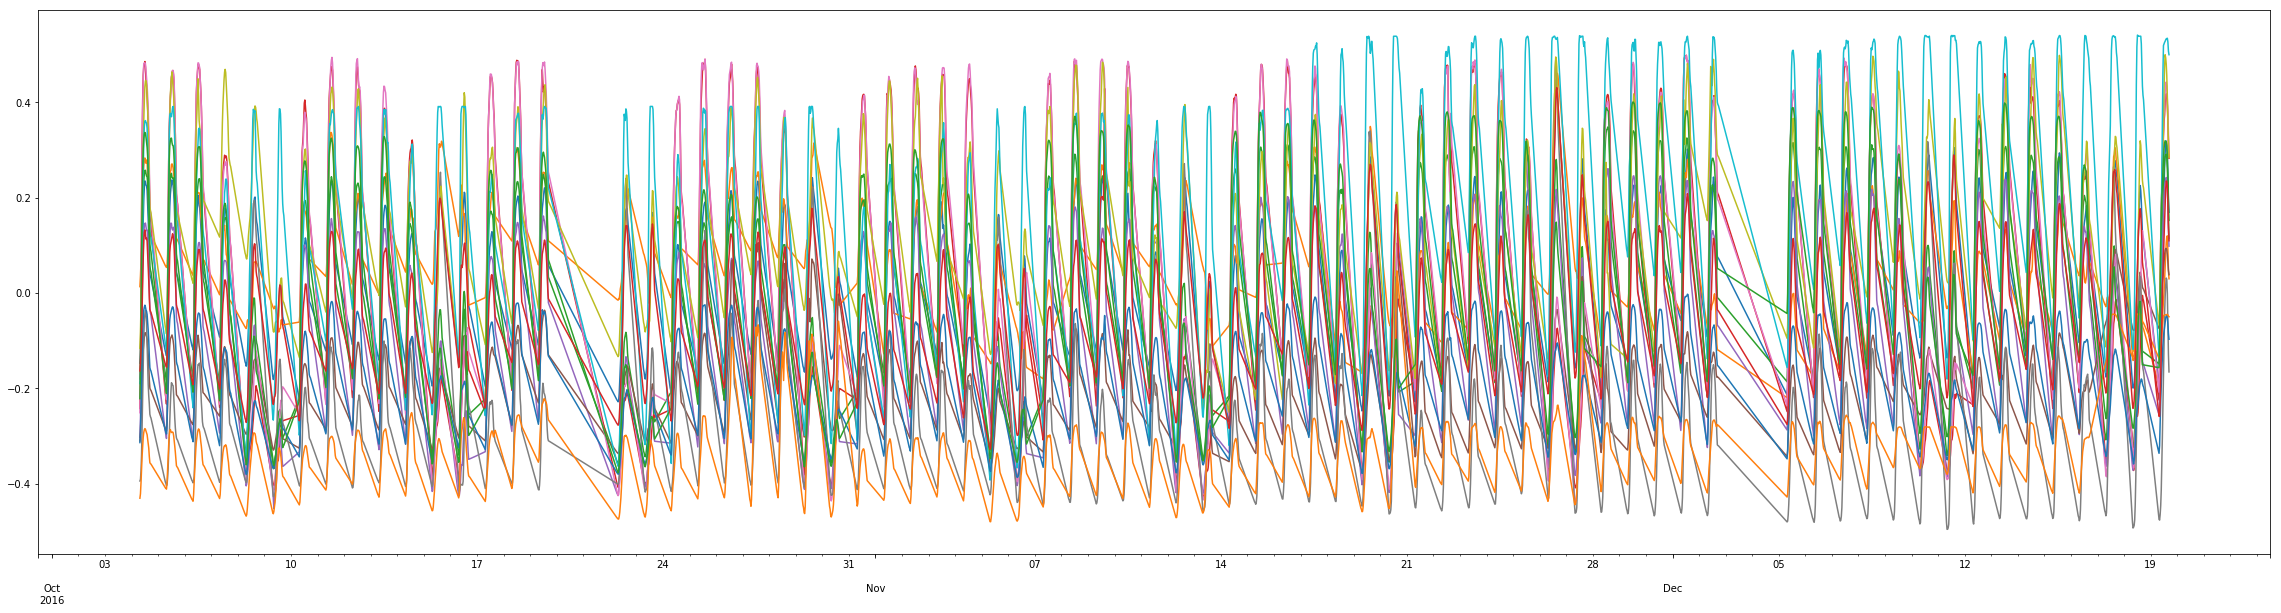

In [61]:
for k, (v, capacity) in ds_rescale.items():
    v.plot(figsize=(40, 10))

# Part B. Machine Learning

## `split_by_week()` -- Training/Validation set split helper function

For training and validation, we first split carpark data into *weeks*. The specified number of weeks will be used for validation, and the other weeks are used for training.

In [62]:
def split_by_week(dataset, validation_size=2):
    """
    Input: (DataFrame, capacity)
    Output: (DataFrame for training, DataFrame for validation, capacity)
    """
    v, capacity = dataset
    groups = list(d for _, d in v.groupby(v.index.weekofyear))
    return (pd.concat(groups[:-validation_size]), pd.concat(groups[-validation_size:]), capacity)

## `genslide()` -- Sliding window construction helper function

LSTM works by passing it `t - 1`, `t - 2`, `t - n` past data elements, and then asking it to predict `t`, `t + 1` ... `t + m - 1`.
To do this we need a helper function to generate a sliding window of `n + m` elements over the data.

In [63]:
def genslide(data, n, m):
    """input: numpy array with shape (numrows, numcols)
    output: (inputs, targets), where inputs is a numpy array with shape (numrows - (n + m) + 1, n, numcols)
    and targets is a numpy array with shape (numrows - (n + m) + 1, m * numcols)
    Notice for targets that the last two shape components are flattened.
    """
    assert data.ndim == 2 or data.ndim == 1, "input must be numpy array with shape (numrows, numcols). ndim is {0}".format(data.ndim)
    if data.ndim == 1:
        data = data.reshape(data.shape[0], 1)
    numrows, numcols = data.shape
    outrows = max(numrows - (n + m) + 1, 0)
    out_inputs = np.empty((outrows, n, numcols), dtype=np.float32)
    out_targets = np.empty((outrows, m, numcols), dtype=np.float32)
    for i in range(0, outrows):
        out_inputs[i] = data[i:i+n]
        out_targets[i] = data[i+n:i+n+m]
    out_targets = out_targets.reshape(outrows, m * numcols)
    assert out_inputs.shape == (outrows, n, numcols)
    assert out_targets.shape == (outrows, m * numcols)
    return out_inputs, out_targets

## `train_model()` -- Model setup and training helper function

We use mean squared error as the error measure.

In [64]:
def train_model(train_data, eval_data, n, m, num_lstm_layers, hidden_size, batch_size, epochs):
    """
    data: Pandas DataFrame containing the training carpark data.
    n: Number of past data points
    m: Number of output data points to predict
    hidden_size: The number of LSTM units
    """
    train_data_inputs, train_data_targets = genslide(train_data.values, n, m)
    eval_data_inputs, eval_data_targets = genslide(eval_data.values, n, m)
    assert train_data_inputs.ndim == 3
    assert train_data_targets.ndim == 2
    assert eval_data_inputs.ndim == 3
    assert eval_data_targets.ndim == 2
    seqs = []
    lstmLayerType = tf.keras.layers.CuDNNLSTM if tf.test.is_gpu_available(cuda_only=True) else tf.keras.layers.LSTM
    for i in range(num_lstm_layers):
        seqs.append(lstmLayerType(hidden_size, return_sequences=(i != num_lstm_layers - 1)))
    seqs.append(tf.keras.layers.Dense(train_data_targets.shape[1]))
    model = tf.keras.Sequential(seqs)
    model.compile(loss='mean_squared_error', optimizer=tf.train.RMSPropOptimizer(0.001))
    cbs = []
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('./tmp.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
    cbs.append(checkpoint_cb)
    history = model.fit(train_data_inputs, train_data_targets, validation_data=(eval_data_inputs, eval_data_targets), batch_size=batch_size, epochs=epochs, callbacks=cbs)
    model.load_weights('./tmp.hdf5')
    return model, history

## `train_plot()` -- Plot loss vs val_loss over training epochs

In [65]:
def train_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.yscale('log')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

## `evaluate_model()` -- Helper function for evaluating model by calculating mean squared error

In [66]:
def evaluate_model(model, data, n, m, batch_size):
    """
    model: Trained model
    data: Pandas dataframe containing carpark data for evaluation
    Returns: (np.float64) mean squared error
    """
    data_inputs, data_targets = genslide(data.values, n, m)
    assert data_inputs.ndim == 3
    assert data_targets.ndim == 2
    return model.evaluate(data_inputs, data_targets, batch_size=batch_size)

## `evaluate_model_plot()` -- Helper function for evaluating model by plotting predicted + actual on graph

In [120]:
def evaluate_model_plot(model, data, n, m, fn=None):
    data_inputs, data_targets = genslide(data.values, n, m)
    _, _, numcols = data_inputs.shape
    out_data = []
    out_indexes = []
    for i, (inp, tgt) in enumerate(zip(data_inputs, data_targets)):
        out_indexes.extend(data.index[i + n + z] for z in range(m))
        inp = inp.reshape(1, *inp.shape)
        vals = model.predict(inp)
        vals = vals.reshape(m, numcols)
        vals = vals[:, 0]
        out_data.extend(map(fn, vals) if fn else vals)
    df = pd.DataFrame(out_data, index=out_indexes)
    ax = df.plot(style='.', label='Predicated', figsize=(8, 5))
    data = data['Occupancy']
    if fn:
        data = data.map(fn)
    data.plot(ax=ax, style='+', label='Actual')
    ax.legend(['Predicted', 'Actual'])

# Evaluation on BHMBCCMKT01

All experiments use a validation set size of *2 weeks*, and predict 2 hours ahead using 6 hours worth of prior data.

## Baseline: One LSTM Layer, 40 Units

In [105]:
%%time
data = dataset['BHMBCCMKT01']
n, m = 6 * 2, 2 * 2  # Predict 2 hour ahead using 6 hours worth of past data
train_set, eval_set, capacity = split_by_week(data, validation_size=2)
model, history = train_model(train_set, eval_set, n, m,
                    num_lstm_layers=1,
                    hidden_size=40,
                    batch_size=32,
                    epochs=1000)
model, history

Train on 3282 samples, validate on 355 samples
Epoch 1/1000
3282/3282 [==============================] - 4s 1ms/step - loss: 0.0725 - val_loss: 0.0500
Epoch 2/1000
3282/3282 [==============================] - 1s 160us/step - loss: 0.0401 - val_loss: 0.0281
Epoch 3/1000
3282/3282 [==============================] - 1s 165us/step - loss: 0.0221 - val_loss: 0.0162
Epoch 4/1000
3282/3282 [==============================] - 1s 153us/step - loss: 0.0131 - val_loss: 0.0123
Epoch 5/1000
3282/3282 [==============================] - 1s 170us/step - loss: 0.0100 - val_loss: 0.0106
Epoch 6/1000
3282/3282 [==============================] - 1s 163us/step - loss: 0.0079 - val_loss: 0.0078
Epoch 7/1000
3282/3282 [==============================] - 1s 159us/step - loss: 0.0063 - val_loss: 0.0131
Epoch 8/1000
3282/3282 [==============================] - 0s 141us/step - loss: 0.0055 - val_loss: 0.0045
Epoch 9/1000
3282/3282 [==============================] - 0s 140us/step - loss: 0.0048 - val_loss: 0.0049
E

Epoch 76/1000
3282/3282 [==============================] - 0s 152us/step - loss: 0.0010 - val_loss: 4.0422e-04
Epoch 77/1000
3282/3282 [==============================] - 0s 151us/step - loss: 7.9912e-04 - val_loss: 4.5586e-04
Epoch 78/1000
3282/3282 [==============================] - 0s 149us/step - loss: 8.6721e-04 - val_loss: 4.1111e-04
Epoch 79/1000
3282/3282 [==============================] - 1s 152us/step - loss: 0.0010 - val_loss: 5.4674e-04
Epoch 80/1000
3282/3282 [==============================] - 1s 157us/step - loss: 7.6012e-04 - val_loss: 3.9067e-04
Epoch 81/1000
3282/3282 [==============================] - 0s 151us/step - loss: 9.8970e-04 - val_loss: 3.9893e-04
Epoch 82/1000
3282/3282 [==============================] - 0s 150us/step - loss: 8.2422e-04 - val_loss: 0.0028
Epoch 83/1000
3282/3282 [==============================] - 0s 145us/step - loss: 8.5546e-04 - val_loss: 4.9213e-04
Epoch 84/1000
3282/3282 [==============================] - 0s 149us/step - loss: 7.3276e-04 

Epoch 218/1000
3282/3282 [==============================] - 1s 153us/step - loss: 4.7138e-04 - val_loss: 3.8552e-04
Epoch 219/1000
3282/3282 [==============================] - 0s 152us/step - loss: 3.2497e-04 - val_loss: 2.7634e-04
Epoch 220/1000
3282/3282 [==============================] - 1s 156us/step - loss: 4.7815e-04 - val_loss: 3.3300e-04
Epoch 221/1000
3282/3282 [==============================] - 1s 155us/step - loss: 4.9164e-04 - val_loss: 2.3874e-04
Epoch 222/1000
3282/3282 [==============================] - 0s 151us/step - loss: 3.6025e-04 - val_loss: 2.8911e-04
Epoch 223/1000
3282/3282 [==============================] - 0s 145us/step - loss: 3.6894e-04 - val_loss: 3.0162e-04
Epoch 224/1000
3282/3282 [==============================] - 0s 151us/step - loss: 4.1963e-04 - val_loss: 2.5181e-04
Epoch 225/1000
3282/3282 [==============================] - 0s 151us/step - loss: 3.4317e-04 - val_loss: 3.8648e-04
Epoch 226/1000
3282/3282 [==============================] - 0s 149us/ste

Epoch 359/1000
3282/3282 [==============================] - 0s 149us/step - loss: 2.8890e-04 - val_loss: 2.1780e-04
Epoch 360/1000
3282/3282 [==============================] - 0s 149us/step - loss: 2.8583e-04 - val_loss: 2.8849e-04
Epoch 361/1000
3282/3282 [==============================] - 0s 151us/step - loss: 3.7080e-04 - val_loss: 0.0057
Epoch 362/1000
3282/3282 [==============================] - 1s 157us/step - loss: 3.2917e-04 - val_loss: 2.5091e-04
Epoch 363/1000
3282/3282 [==============================] - 0s 150us/step - loss: 3.0535e-04 - val_loss: 2.1269e-04
Epoch 364/1000
3282/3282 [==============================] - 0s 147us/step - loss: 3.5194e-04 - val_loss: 2.8072e-04
Epoch 365/1000
3282/3282 [==============================] - 0s 152us/step - loss: 2.6063e-04 - val_loss: 2.1742e-04
Epoch 366/1000
3282/3282 [==============================] - 1s 153us/step - loss: 2.5526e-04 - val_loss: 2.5878e-04
Epoch 367/1000
3282/3282 [==============================] - 0s 151us/step - 

Epoch 500/1000
3282/3282 [==============================] - 1s 168us/step - loss: 2.2615e-04 - val_loss: 2.2313e-04
Epoch 501/1000
3282/3282 [==============================] - 1s 173us/step - loss: 2.2770e-04 - val_loss: 2.3572e-04
Epoch 502/1000
3282/3282 [==============================] - 1s 175us/step - loss: 2.5236e-04 - val_loss: 3.2372e-04
Epoch 503/1000
3282/3282 [==============================] - 1s 170us/step - loss: 3.1785e-04 - val_loss: 2.6318e-04
Epoch 504/1000
3282/3282 [==============================] - 1s 169us/step - loss: 3.1145e-04 - val_loss: 2.3453e-04
Epoch 505/1000
3282/3282 [==============================] - 1s 154us/step - loss: 2.8460e-04 - val_loss: 2.2575e-04
Epoch 506/1000
3282/3282 [==============================] - 0s 147us/step - loss: 2.3118e-04 - val_loss: 2.0997e-04
Epoch 507/1000
3282/3282 [==============================] - 1s 166us/step - loss: 3.2705e-04 - val_loss: 2.3067e-04
Epoch 508/1000
3282/3282 [==============================] - 1s 172us/ste

Epoch 641/1000
3282/3282 [==============================] - 1s 161us/step - loss: 2.3858e-04 - val_loss: 2.2386e-04
Epoch 642/1000
3282/3282 [==============================] - 1s 165us/step - loss: 2.7160e-04 - val_loss: 2.3680e-04
Epoch 643/1000
3282/3282 [==============================] - 1s 161us/step - loss: 2.1884e-04 - val_loss: 2.4313e-04
Epoch 644/1000
3282/3282 [==============================] - 1s 170us/step - loss: 2.2877e-04 - val_loss: 2.1337e-04
Epoch 645/1000
3282/3282 [==============================] - 0s 134us/step - loss: 2.6038e-04 - val_loss: 2.0883e-04
Epoch 646/1000
3282/3282 [==============================] - 1s 160us/step - loss: 2.2576e-04 - val_loss: 2.2675e-04
Epoch 647/1000
3282/3282 [==============================] - 1s 162us/step - loss: 2.0322e-04 - val_loss: 2.4580e-04
Epoch 648/1000
3282/3282 [==============================] - 1s 165us/step - loss: 2.3261e-04 - val_loss: 2.5864e-04
Epoch 649/1000
3282/3282 [==============================] - 1s 155us/ste

Epoch 782/1000
3282/3282 [==============================] - 1s 162us/step - loss: 2.4311e-04 - val_loss: 2.1640e-04
Epoch 783/1000
3282/3282 [==============================] - 1s 159us/step - loss: 2.1028e-04 - val_loss: 2.0611e-04
Epoch 784/1000
3282/3282 [==============================] - 1s 168us/step - loss: 2.4677e-04 - val_loss: 3.6909e-04
Epoch 785/1000
3282/3282 [==============================] - 1s 163us/step - loss: 2.2067e-04 - val_loss: 2.4491e-04
Epoch 786/1000
3282/3282 [==============================] - 1s 175us/step - loss: 2.3987e-04 - val_loss: 2.2420e-04
Epoch 787/1000
3282/3282 [==============================] - 1s 179us/step - loss: 2.0359e-04 - val_loss: 2.1467e-04
Epoch 788/1000
3282/3282 [==============================] - 1s 171us/step - loss: 2.4572e-04 - val_loss: 2.2332e-04
Epoch 789/1000
3282/3282 [==============================] - 1s 166us/step - loss: 2.1280e-04 - val_loss: 2.4058e-04
Epoch 790/1000
3282/3282 [==============================] - 1s 171us/ste

Epoch 923/1000
3282/3282 [==============================] - 1s 170us/step - loss: 2.6980e-04 - val_loss: 2.2577e-04
Epoch 924/1000
3282/3282 [==============================] - 1s 169us/step - loss: 2.3820e-04 - val_loss: 2.7104e-04
Epoch 925/1000
3282/3282 [==============================] - 1s 169us/step - loss: 1.6666e-04 - val_loss: 2.5971e-04
Epoch 926/1000
3282/3282 [==============================] - 1s 167us/step - loss: 2.2480e-04 - val_loss: 2.2592e-04
Epoch 927/1000
3282/3282 [==============================] - 1s 172us/step - loss: 2.0641e-04 - val_loss: 2.1907e-04
Epoch 928/1000
3282/3282 [==============================] - 1s 174us/step - loss: 1.8336e-04 - val_loss: 2.1350e-04
Epoch 929/1000
3282/3282 [==============================] - 1s 163us/step - loss: 2.2971e-04 - val_loss: 2.4017e-04
Epoch 930/1000
3282/3282 [==============================] - 1s 174us/step - loss: 1.9894e-04 - val_loss: 2.3650e-04
Epoch 931/1000
3282/3282 [==============================] - 0s 149us/ste

Epoch 994/1000
3282/3282 [==============================] - 1s 165us/step - loss: 2.0127e-04 - val_loss: 2.4958e-04
Epoch 995/1000
3282/3282 [==============================] - 1s 175us/step - loss: 1.8834e-04 - val_loss: 2.4303e-04
Epoch 996/1000
3282/3282 [==============================] - 1s 168us/step - loss: 2.1704e-04 - val_loss: 2.2006e-04
Epoch 997/1000
3282/3282 [==============================] - 1s 177us/step - loss: 1.9918e-04 - val_loss: 2.5599e-04
Epoch 998/1000
3282/3282 [==============================] - 1s 175us/step - loss: 1.8757e-04 - val_loss: 2.3267e-04
Epoch 999/1000
3282/3282 [==============================] - 1s 173us/step - loss: 2.0818e-04 - val_loss: 2.7548e-04
Epoch 1000/1000
3282/3282 [==============================] - 1s 156us/step - loss: 1.8005e-04 - val_loss: 3.1085e-04
CPU times: user 12min 31s, sys: 2min 1s, total: 14min 32s
Wall time: 8min 46s


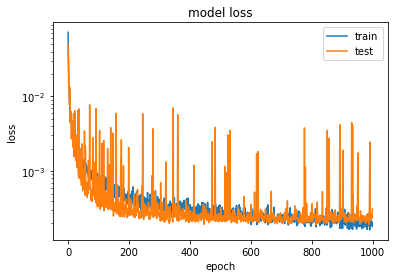

In [106]:
train_plot(history)

In [107]:
evaluate_model(model, eval_set, n, m, batch_size=32)

355/355 [==============================] - 0s 90us/step


0.0001907562166386822

In [108]:
math.sqrt(evaluate_model(model, eval_set, n, m, batch_size=32))

355/355 [==============================] - 0s 77us/step


0.013811452372530638

In [109]:
capacity, math.sqrt(evaluate_model(model, eval_set, n, m, batch_size=32)) * capacity

355/355 [==============================] - 0s 69us/step


(577, 7.969208018950178)

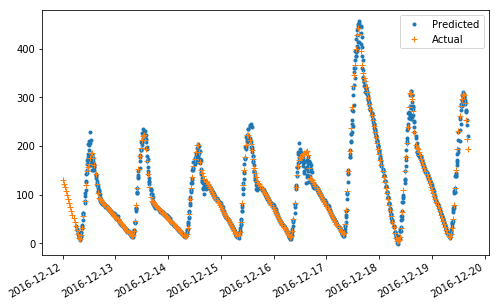

In [121]:
evaluate_model_plot(model, eval_set, n, m, lambda x: (x + 0.5) * capacity)

## Does number of units matter? One LSTM Layer, 100 units

In [77]:
%%time
data = dataset['BHMBCCMKT01']
n, m = 12, 4  # Predict 2 hour ahead using 6 hours worth of past data
train_set, eval_set, capacity = split_by_week(data, validation_size=2)
model, history = train_model(train_set, eval_set, n, m,
                    num_lstm_layers=1,
                    hidden_size=100,
                    batch_size=32,
                    epochs=800)
model, history

Train on 3282 samples, validate on 355 samples
Epoch 1/800
3282/3282 [==============================] - 3s 768us/step - loss: 0.0769 - val_loss: 0.0498
Epoch 2/800
3282/3282 [==============================] - 1s 178us/step - loss: 0.0376 - val_loss: 0.0260
Epoch 3/800
3282/3282 [==============================] - 0s 148us/step - loss: 0.0195 - val_loss: 0.0133
Epoch 4/800
3282/3282 [==============================] - 0s 147us/step - loss: 0.0123 - val_loss: 0.0088
Epoch 5/800
3282/3282 [==============================] - 1s 161us/step - loss: 0.0087 - val_loss: 0.0153
Epoch 6/800
3282/3282 [==============================] - 1s 169us/step - loss: 0.0071 - val_loss: 0.0053
Epoch 7/800
3282/3282 [==============================] - 1s 162us/step - loss: 0.0061 - val_loss: 0.0046
Epoch 8/800
3282/3282 [==============================] - 1s 171us/step - loss: 0.0055 - val_loss: 0.0038
Epoch 9/800
3282/3282 [==============================] - 1s 157us/step - loss: 0.0048 - val_loss: 0.0048
Epoch 10

Epoch 148/800
3282/3282 [==============================] - 1s 174us/step - loss: 5.3420e-04 - val_loss: 2.9051e-04
Epoch 149/800
3282/3282 [==============================] - 1s 179us/step - loss: 5.0669e-04 - val_loss: 2.8513e-04
Epoch 150/800
3282/3282 [==============================] - 1s 169us/step - loss: 5.0178e-04 - val_loss: 2.8344e-04
Epoch 151/800
3282/3282 [==============================] - 1s 183us/step - loss: 6.4324e-04 - val_loss: 2.7728e-04
Epoch 152/800
3282/3282 [==============================] - 1s 175us/step - loss: 6.3802e-04 - val_loss: 2.7915e-04
Epoch 153/800
3282/3282 [==============================] - 1s 178us/step - loss: 4.2910e-04 - val_loss: 3.0687e-04
Epoch 154/800
3282/3282 [==============================] - 1s 177us/step - loss: 6.4109e-04 - val_loss: 4.8997e-04
Epoch 155/800
3282/3282 [==============================] - 1s 183us/step - loss: 6.7429e-04 - val_loss: 2.6964e-04
Epoch 156/800
3282/3282 [==============================] - 1s 176us/step - loss:

3282/3282 [==============================] - 1s 172us/step - loss: 3.6421e-04 - val_loss: 2.1238e-04
Epoch 291/800
3282/3282 [==============================] - 1s 161us/step - loss: 4.4835e-04 - val_loss: 2.2818e-04
Epoch 292/800
3282/3282 [==============================] - 1s 153us/step - loss: 2.5784e-04 - val_loss: 2.5496e-04
Epoch 293/800
3282/3282 [==============================] - 1s 163us/step - loss: 4.1105e-04 - val_loss: 2.8069e-04
Epoch 294/800
3282/3282 [==============================] - 1s 164us/step - loss: 3.4827e-04 - val_loss: 2.2881e-04
Epoch 295/800
3282/3282 [==============================] - 0s 141us/step - loss: 3.3532e-04 - val_loss: 2.4628e-04
Epoch 296/800
3282/3282 [==============================] - 0s 150us/step - loss: 3.4245e-04 - val_loss: 2.4587e-04
Epoch 297/800
3282/3282 [==============================] - 1s 168us/step - loss: 4.4601e-04 - val_loss: 2.4159e-04
Epoch 298/800
3282/3282 [==============================] - 0s 143us/step - loss: 3.9730e-04 - 

3282/3282 [==============================] - 1s 165us/step - loss: 2.3257e-04 - val_loss: 2.2775e-04
Epoch 433/800
3282/3282 [==============================] - 1s 179us/step - loss: 3.0354e-04 - val_loss: 2.3774e-04
Epoch 434/800
3282/3282 [==============================] - 1s 180us/step - loss: 2.7461e-04 - val_loss: 2.7102e-04
Epoch 435/800
3282/3282 [==============================] - 1s 184us/step - loss: 2.6389e-04 - val_loss: 2.9398e-04
Epoch 436/800
3282/3282 [==============================] - 1s 176us/step - loss: 3.2487e-04 - val_loss: 2.3022e-04
Epoch 437/800
3282/3282 [==============================] - 1s 173us/step - loss: 2.3553e-04 - val_loss: 2.1604e-04
Epoch 438/800
3282/3282 [==============================] - 1s 169us/step - loss: 2.7148e-04 - val_loss: 3.5134e-04
Epoch 439/800
3282/3282 [==============================] - 0s 147us/step - loss: 3.1864e-04 - val_loss: 2.2934e-04
Epoch 440/800
3282/3282 [==============================] - 1s 160us/step - loss: 2.4433e-04 - 

3282/3282 [==============================] - 0s 142us/step - loss: 2.3976e-04 - val_loss: 2.3429e-04
Epoch 575/800
3282/3282 [==============================] - 0s 149us/step - loss: 2.9835e-04 - val_loss: 2.7003e-04
Epoch 576/800
3282/3282 [==============================] - 0s 142us/step - loss: 2.4959e-04 - val_loss: 2.0283e-04
Epoch 577/800
3282/3282 [==============================] - 0s 142us/step - loss: 2.2553e-04 - val_loss: 2.4027e-04
Epoch 578/800
3282/3282 [==============================] - 0s 130us/step - loss: 3.7576e-04 - val_loss: 1.9182e-04
Epoch 579/800
3282/3282 [==============================] - 0s 134us/step - loss: 2.2568e-04 - val_loss: 1.9233e-04
Epoch 580/800
3282/3282 [==============================] - 0s 139us/step - loss: 2.2807e-04 - val_loss: 2.3556e-04
Epoch 581/800
3282/3282 [==============================] - 0s 151us/step - loss: 2.1296e-04 - val_loss: 2.4189e-04
Epoch 582/800
3282/3282 [==============================] - 0s 137us/step - loss: 3.6855e-04 - 

3282/3282 [==============================] - 1s 164us/step - loss: 1.7617e-04 - val_loss: 2.2051e-04
Epoch 717/800
3282/3282 [==============================] - 1s 153us/step - loss: 2.2859e-04 - val_loss: 2.3044e-04
Epoch 718/800
3282/3282 [==============================] - 1s 153us/step - loss: 2.4216e-04 - val_loss: 2.7325e-04
Epoch 719/800
3282/3282 [==============================] - 1s 152us/step - loss: 3.4625e-04 - val_loss: 2.1737e-04
Epoch 720/800
3282/3282 [==============================] - 0s 151us/step - loss: 2.6935e-04 - val_loss: 2.1349e-04
Epoch 721/800
3282/3282 [==============================] - 0s 146us/step - loss: 2.3252e-04 - val_loss: 2.3817e-04
Epoch 722/800
3282/3282 [==============================] - 1s 155us/step - loss: 1.9786e-04 - val_loss: 2.4042e-04
Epoch 723/800
3282/3282 [==============================] - 1s 159us/step - loss: 2.0154e-04 - val_loss: 2.4696e-04
Epoch 724/800
3282/3282 [==============================] - 1s 163us/step - loss: 2.1890e-04 - 

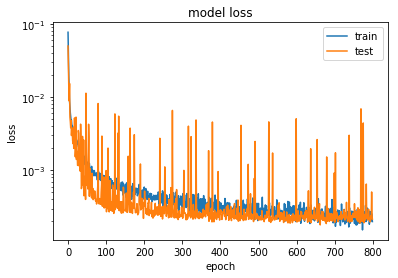

In [78]:
train_plot(history)

In [79]:
evaluate_model(model, eval_set, n, m, batch_size=32)

355/355 [==============================] - 0s 82us/step


0.0001795230718234449

In [80]:
math.sqrt(evaluate_model(model, eval_set, n, m, batch_size=32))

355/355 [==============================] - 0s 65us/step


0.013398622012111727

In [81]:
math.sqrt(evaluate_model(model, eval_set, n, m, batch_size=32)) * capacity

355/355 [==============================] - 0s 71us/step


7.7310049009884665

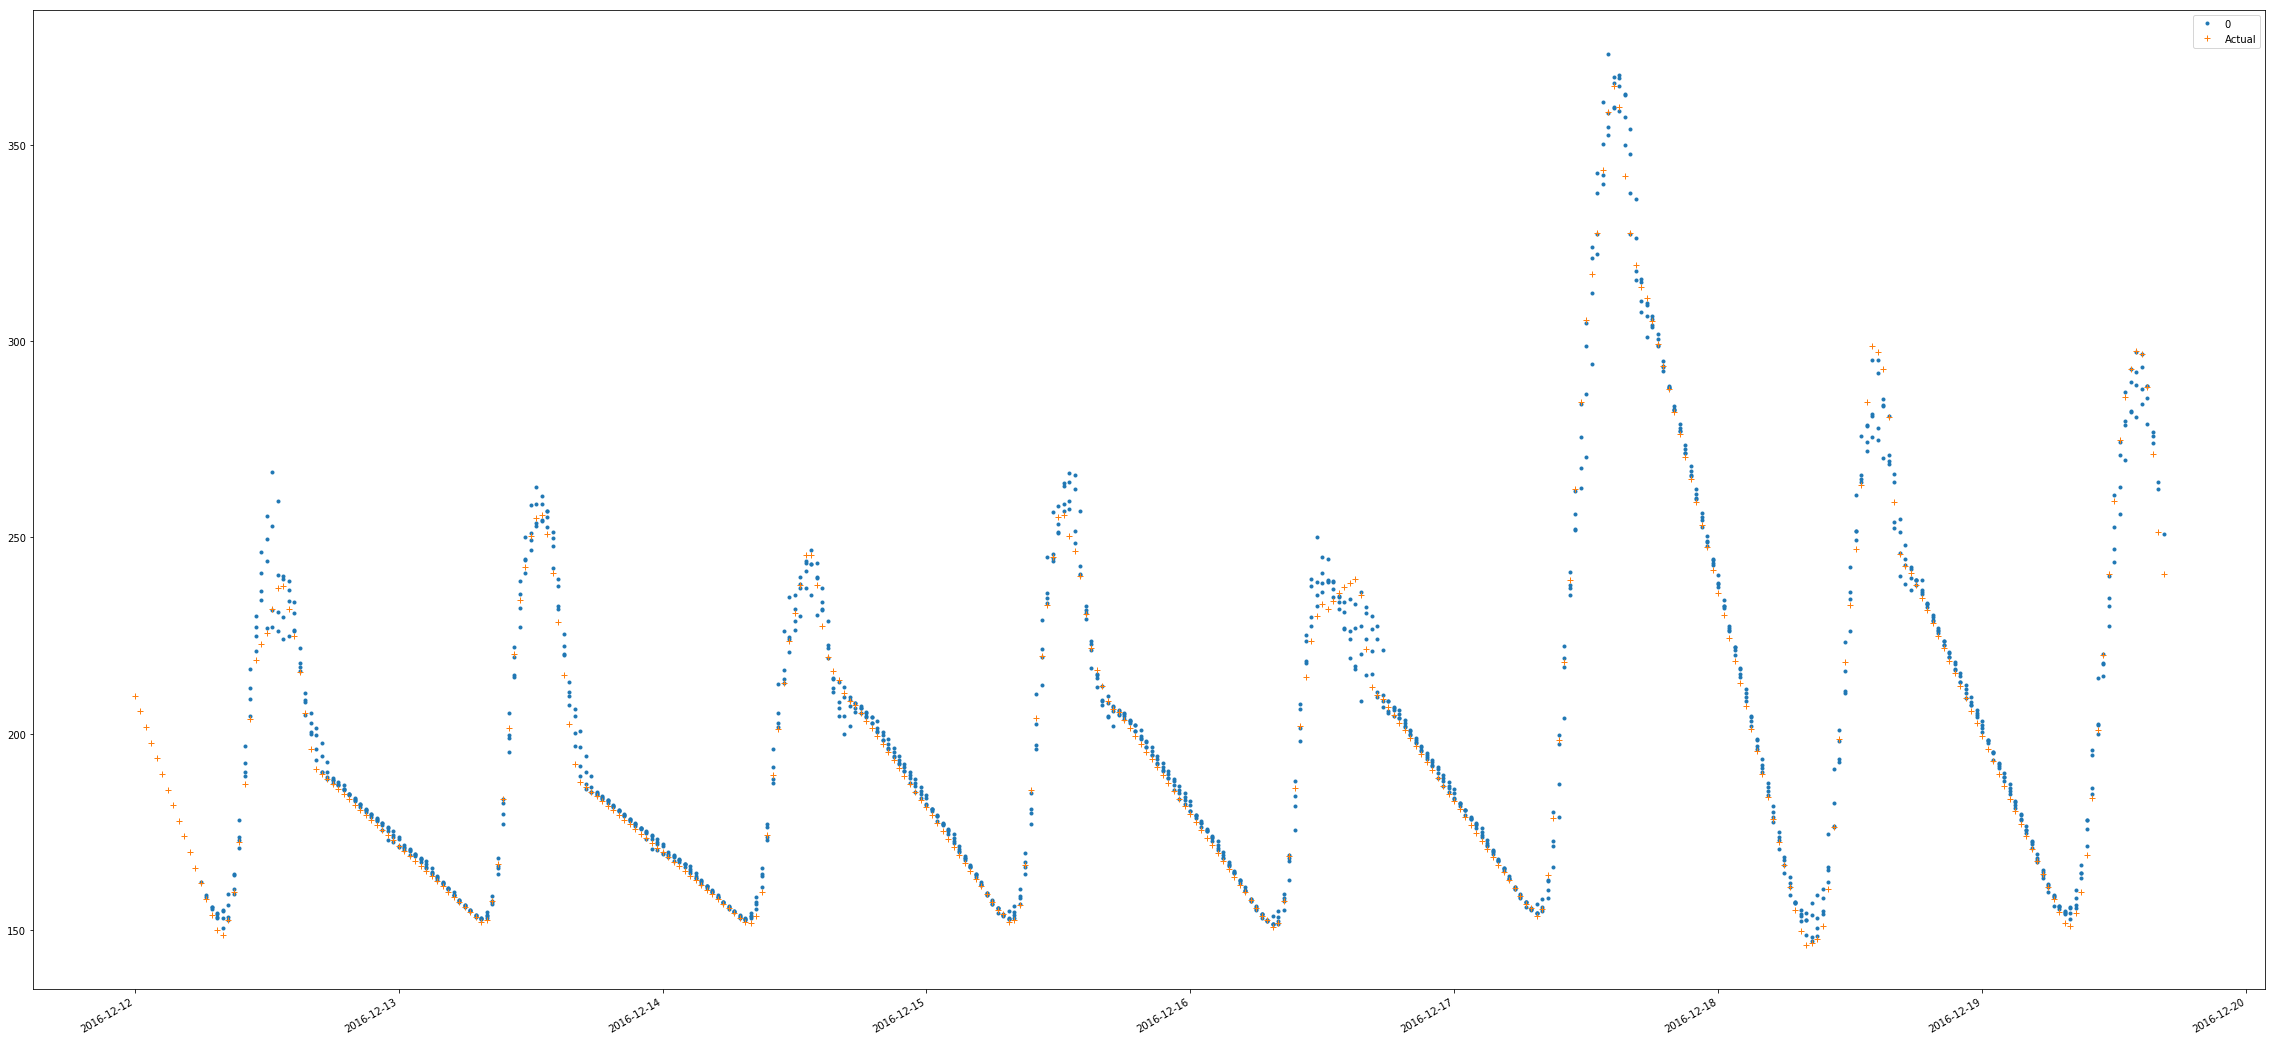

In [82]:
evaluate_model_plot(model, eval_set, n, m, lambda x: ((x + 1.0) / 2.0) * capacity)

## How about stacking additional layers? Two LSTM layers, 40 units

In [85]:
%%time
data = dataset['BHMBCCMKT01']
n, m = 12, 4  # Predict 2 hour ahead using 6 hours worth of past data
train_set, eval_set, capacity = split_by_week(data, validation_size=2)
model, history = train_model(train_set, eval_set, n, m,
                    num_lstm_layers=2,
                    hidden_size=40,
                    batch_size=32,
                    epochs=800)
model, history

Train on 3282 samples, validate on 355 samples
Epoch 1/800
3282/3282 [==============================] - 3s 1ms/step - loss: 0.0736 - val_loss: 0.0505
Epoch 2/800
3282/3282 [==============================] - 1s 239us/step - loss: 0.0426 - val_loss: 0.0289
Epoch 3/800
3282/3282 [==============================] - 1s 219us/step - loss: 0.0209 - val_loss: 0.0160
Epoch 4/800
3282/3282 [==============================] - 1s 208us/step - loss: 0.0119 - val_loss: 0.0125
Epoch 5/800
3282/3282 [==============================] - 1s 215us/step - loss: 0.0088 - val_loss: 0.0078
Epoch 6/800
3282/3282 [==============================] - 1s 206us/step - loss: 0.0073 - val_loss: 0.0073
Epoch 7/800
3282/3282 [==============================] - 1s 218us/step - loss: 0.0063 - val_loss: 0.0073
Epoch 8/800
3282/3282 [==============================] - 1s 221us/step - loss: 0.0055 - val_loss: 0.0043
Epoch 9/800
3282/3282 [==============================] - 1s 229us/step - loss: 0.0050 - val_loss: 0.0041
Epoch 10/8

Epoch 148/800
3282/3282 [==============================] - 1s 212us/step - loss: 5.4456e-04 - val_loss: 3.8964e-04
Epoch 149/800
3282/3282 [==============================] - 1s 200us/step - loss: 4.6168e-04 - val_loss: 3.9406e-04
Epoch 150/800
3282/3282 [==============================] - 1s 208us/step - loss: 5.4158e-04 - val_loss: 4.3913e-04
Epoch 151/800
3282/3282 [==============================] - 1s 210us/step - loss: 5.1027e-04 - val_loss: 3.9096e-04
Epoch 152/800
3282/3282 [==============================] - 1s 213us/step - loss: 4.5236e-04 - val_loss: 3.0576e-04
Epoch 153/800
3282/3282 [==============================] - 1s 215us/step - loss: 5.3764e-04 - val_loss: 3.5506e-04
Epoch 154/800
3282/3282 [==============================] - 1s 211us/step - loss: 5.2377e-04 - val_loss: 2.6880e-04
Epoch 155/800
3282/3282 [==============================] - 1s 215us/step - loss: 4.4742e-04 - val_loss: 0.0058
Epoch 156/800
3282/3282 [==============================] - 1s 214us/step - loss: 4.8

3282/3282 [==============================] - 1s 230us/step - loss: 4.1273e-04 - val_loss: 2.2600e-04
Epoch 291/800
3282/3282 [==============================] - 1s 228us/step - loss: 3.4982e-04 - val_loss: 2.1103e-04
Epoch 292/800
3282/3282 [==============================] - 1s 217us/step - loss: 3.3109e-04 - val_loss: 2.2805e-04
Epoch 293/800
3282/3282 [==============================] - 1s 223us/step - loss: 3.5156e-04 - val_loss: 3.2078e-04
Epoch 294/800
3282/3282 [==============================] - 1s 212us/step - loss: 2.7575e-04 - val_loss: 3.8349e-04
Epoch 295/800
3282/3282 [==============================] - 1s 221us/step - loss: 4.3229e-04 - val_loss: 3.4439e-04
Epoch 296/800
3282/3282 [==============================] - 1s 230us/step - loss: 3.8110e-04 - val_loss: 2.7789e-04
Epoch 297/800
3282/3282 [==============================] - 1s 224us/step - loss: 3.5797e-04 - val_loss: 2.3291e-04
Epoch 298/800
3282/3282 [==============================] - 1s 240us/step - loss: 3.3597e-04 - 

3282/3282 [==============================] - 1s 233us/step - loss: 2.5024e-04 - val_loss: 2.4565e-04
Epoch 433/800
3282/3282 [==============================] - 1s 218us/step - loss: 2.4484e-04 - val_loss: 2.3324e-04
Epoch 434/800
3282/3282 [==============================] - 1s 212us/step - loss: 2.5105e-04 - val_loss: 2.4604e-04
Epoch 435/800
3282/3282 [==============================] - 1s 217us/step - loss: 2.3317e-04 - val_loss: 3.8131e-04
Epoch 436/800
3282/3282 [==============================] - 1s 212us/step - loss: 2.5306e-04 - val_loss: 2.5362e-04
Epoch 437/800
3282/3282 [==============================] - 1s 206us/step - loss: 2.8214e-04 - val_loss: 2.9871e-04
Epoch 438/800
3282/3282 [==============================] - 1s 218us/step - loss: 2.5057e-04 - val_loss: 2.8334e-04
Epoch 439/800
3282/3282 [==============================] - 1s 215us/step - loss: 2.6842e-04 - val_loss: 2.3309e-04
Epoch 440/800
3282/3282 [==============================] - 1s 213us/step - loss: 2.1703e-04 - 

3282/3282 [==============================] - 1s 211us/step - loss: 2.5419e-04 - val_loss: 3.1206e-04
Epoch 575/800
3282/3282 [==============================] - 1s 218us/step - loss: 2.6177e-04 - val_loss: 1.8648e-04
Epoch 576/800
3282/3282 [==============================] - 1s 202us/step - loss: 1.9753e-04 - val_loss: 2.4657e-04
Epoch 577/800
3282/3282 [==============================] - 1s 207us/step - loss: 2.5036e-04 - val_loss: 1.9077e-04
Epoch 578/800
3282/3282 [==============================] - 1s 207us/step - loss: 2.0166e-04 - val_loss: 2.2747e-04
Epoch 579/800
3282/3282 [==============================] - 1s 209us/step - loss: 2.1912e-04 - val_loss: 2.1504e-04
Epoch 580/800
3282/3282 [==============================] - 1s 212us/step - loss: 2.4750e-04 - val_loss: 1.8843e-04
Epoch 581/800
3282/3282 [==============================] - 1s 213us/step - loss: 2.2843e-04 - val_loss: 2.7162e-04
Epoch 582/800
3282/3282 [==============================] - 1s 211us/step - loss: 2.4465e-04 - 

3282/3282 [==============================] - 1s 213us/step - loss: 2.3485e-04 - val_loss: 1.8622e-04
Epoch 717/800
3282/3282 [==============================] - 1s 215us/step - loss: 1.9399e-04 - val_loss: 2.0911e-04
Epoch 718/800
3282/3282 [==============================] - 1s 213us/step - loss: 1.9358e-04 - val_loss: 1.8999e-04
Epoch 719/800
3282/3282 [==============================] - 1s 214us/step - loss: 1.9838e-04 - val_loss: 2.0035e-04
Epoch 720/800
3282/3282 [==============================] - 1s 211us/step - loss: 2.0598e-04 - val_loss: 1.9945e-04
Epoch 721/800
3282/3282 [==============================] - 1s 203us/step - loss: 2.3396e-04 - val_loss: 2.0668e-04
Epoch 722/800
3282/3282 [==============================] - 1s 205us/step - loss: 1.5106e-04 - val_loss: 2.2735e-04
Epoch 723/800
3282/3282 [==============================] - 1s 214us/step - loss: 1.7639e-04 - val_loss: 2.3215e-04
Epoch 724/800
3282/3282 [==============================] - 1s 210us/step - loss: 1.8633e-04 - 

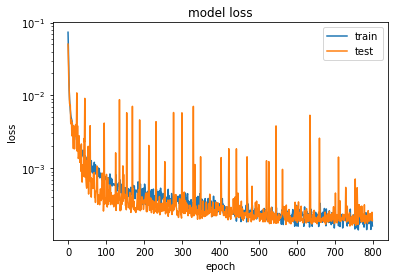

In [86]:
train_plot(history)

In [87]:
evaluate_model(model, eval_set, n, m, batch_size=32)

355/355 [==============================] - 0s 99us/step


0.00016087573144624246

In [88]:
math.sqrt(evaluate_model(model, eval_set, n, m, batch_size=32))

355/355 [==============================] - 0s 88us/step


0.012683679728148392

In [89]:
math.sqrt(evaluate_model(model, eval_set, n, m, batch_size=32)) * capacity

355/355 [==============================] - 0s 91us/step


7.318483203141622

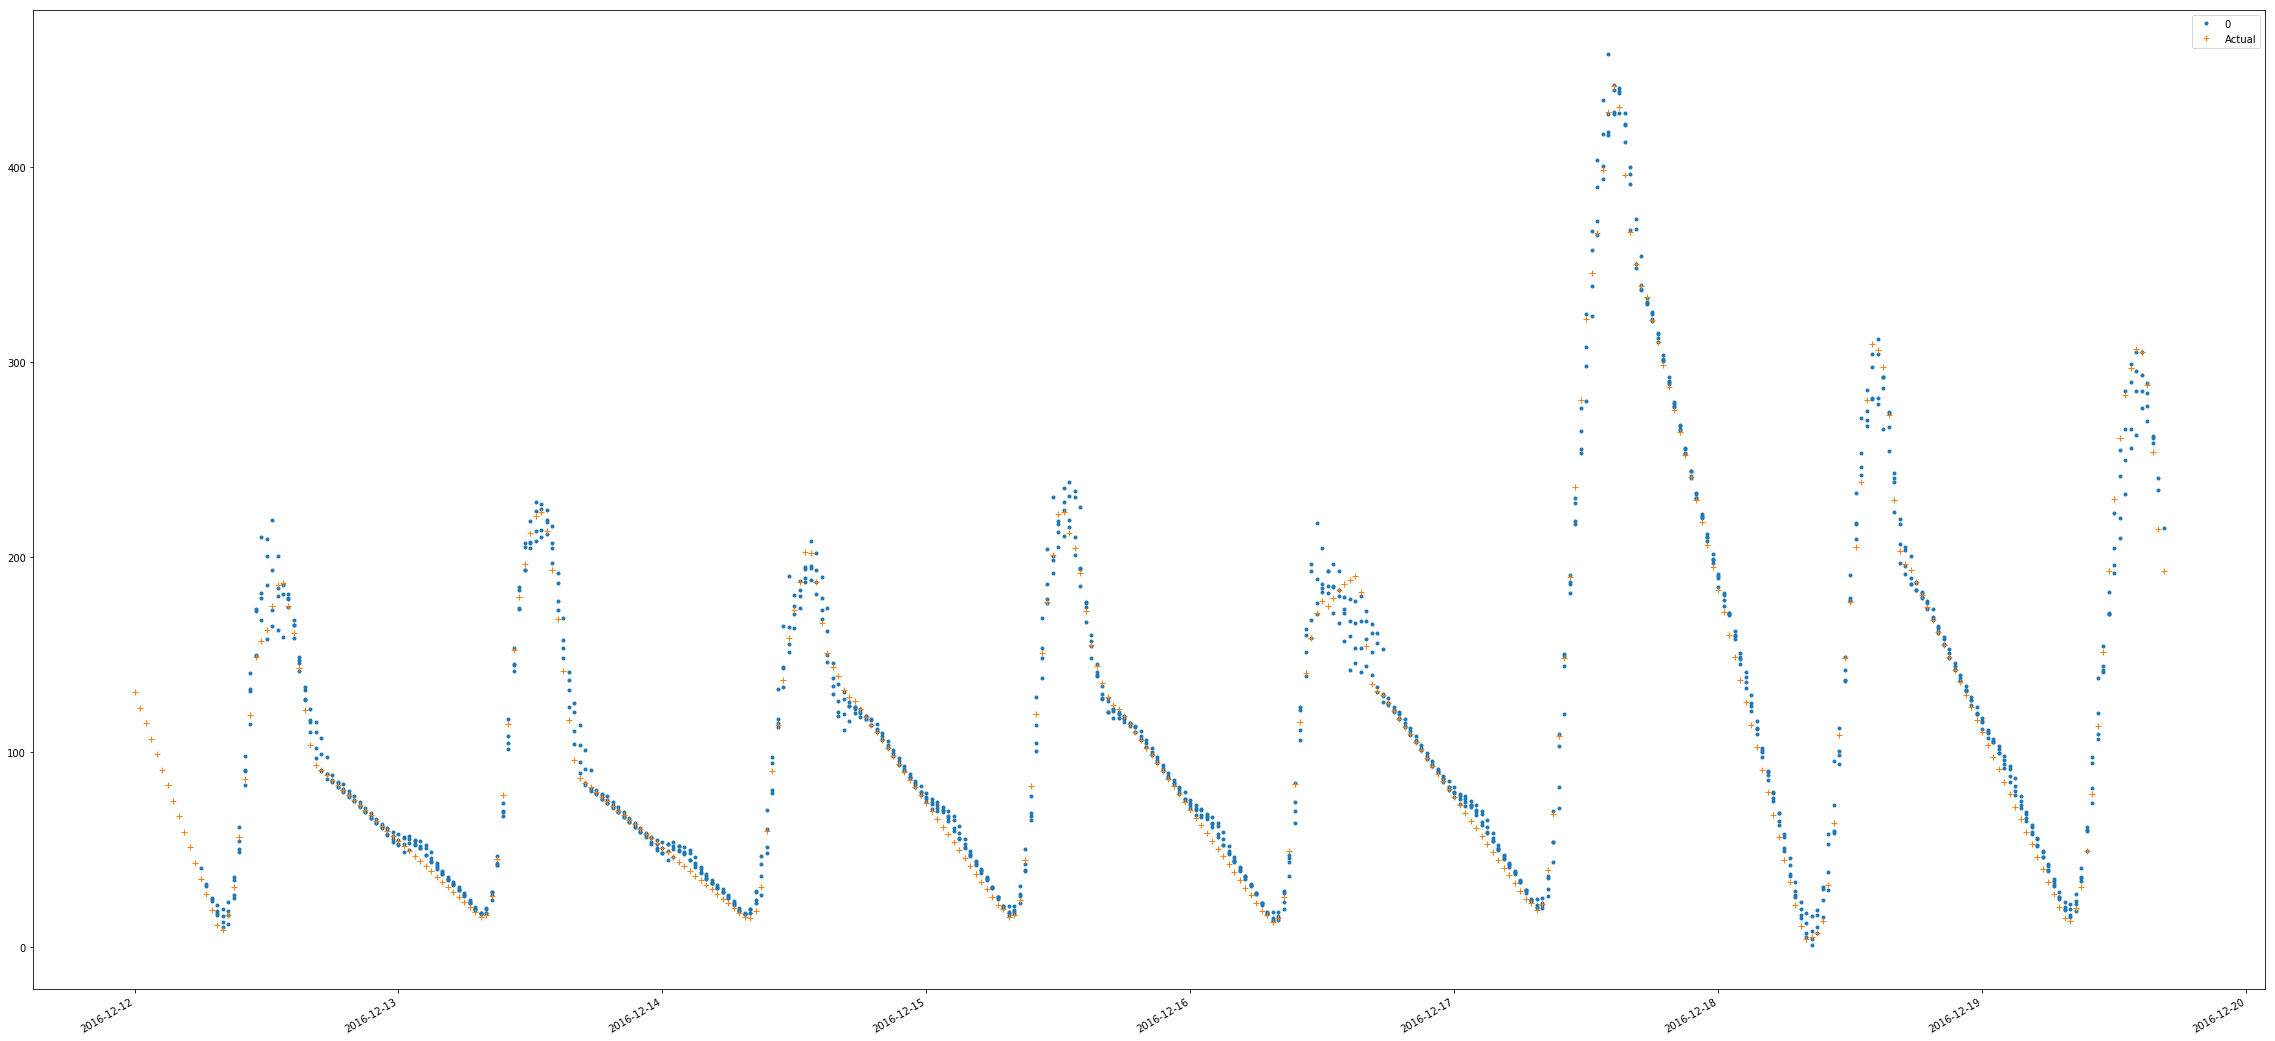

In [41]:
evaluate_model_plot(model, eval_set, n, m, lambda x: ((x + 1.0) / 2.0) * capacity)

## How about more data?

In [90]:
%%time
data = dataset['BHMBCCMKT01']
n, m = 14 * 2, 4  # Predict 2 hour ahead using 8 hours worth of past data
train_set, eval_set, capacity = split_by_week(data, validation_size=2)
model, history = train_model(train_set, eval_set, n, m,
                    num_lstm_layers=1,
                    hidden_size=40,
                    batch_size=32,
                    epochs=800)
model, history

Train on 3266 samples, validate on 339 samples
Epoch 1/800
3266/3266 [==============================] - 3s 1ms/step - loss: 0.0677 - val_loss: 0.0474
Epoch 2/800
3266/3266 [==============================] - 1s 174us/step - loss: 0.0338 - val_loss: 0.0231
Epoch 3/800
3266/3266 [==============================] - 1s 185us/step - loss: 0.0141 - val_loss: 0.0135
Epoch 4/800
3266/3266 [==============================] - 1s 172us/step - loss: 0.0074 - val_loss: 0.0061
Epoch 5/800
3266/3266 [==============================] - 1s 165us/step - loss: 0.0056 - val_loss: 0.0147
Epoch 6/800
3266/3266 [==============================] - 1s 169us/step - loss: 0.0047 - val_loss: 0.0035
Epoch 7/800
3266/3266 [==============================] - 1s 172us/step - loss: 0.0041 - val_loss: 0.0091
Epoch 8/800
3266/3266 [==============================] - 1s 167us/step - loss: 0.0038 - val_loss: 0.0065
Epoch 9/800
3266/3266 [==============================] - 1s 170us/step - loss: 0.0034 - val_loss: 0.0048
Epoch 10/8

3266/3266 [==============================] - 1s 172us/step - loss: 2.9843e-04 - val_loss: 3.5505e-04
Epoch 147/800
3266/3266 [==============================] - 1s 168us/step - loss: 3.4605e-04 - val_loss: 0.0012
Epoch 148/800
3266/3266 [==============================] - 1s 170us/step - loss: 3.0965e-04 - val_loss: 2.6972e-04
Epoch 149/800
3266/3266 [==============================] - 1s 170us/step - loss: 3.0456e-04 - val_loss: 4.2199e-04
Epoch 150/800
3266/3266 [==============================] - 1s 171us/step - loss: 3.0117e-04 - val_loss: 2.7392e-04
Epoch 151/800
3266/3266 [==============================] - 1s 175us/step - loss: 2.9169e-04 - val_loss: 5.3520e-04
Epoch 152/800
3266/3266 [==============================] - 1s 170us/step - loss: 2.9848e-04 - val_loss: 4.3482e-04
Epoch 153/800
3266/3266 [==============================] - 1s 168us/step - loss: 3.3947e-04 - val_loss: 0.0012
Epoch 154/800
3266/3266 [==============================] - 1s 166us/step - loss: 3.7286e-04 - val_loss

3266/3266 [==============================] - 1s 175us/step - loss: 2.1662e-04 - val_loss: 3.0319e-04
Epoch 289/800
3266/3266 [==============================] - 1s 175us/step - loss: 2.4417e-04 - val_loss: 3.2816e-04
Epoch 290/800
3266/3266 [==============================] - 1s 172us/step - loss: 2.3300e-04 - val_loss: 6.3851e-04
Epoch 291/800
3266/3266 [==============================] - 1s 166us/step - loss: 2.9266e-04 - val_loss: 3.2217e-04
Epoch 292/800
3266/3266 [==============================] - 1s 172us/step - loss: 2.6576e-04 - val_loss: 2.3749e-04
Epoch 293/800
3266/3266 [==============================] - 1s 169us/step - loss: 2.5091e-04 - val_loss: 4.1235e-04
Epoch 294/800
3266/3266 [==============================] - 1s 164us/step - loss: 2.6017e-04 - val_loss: 3.1055e-04
Epoch 295/800
3266/3266 [==============================] - 1s 167us/step - loss: 2.0043e-04 - val_loss: 2.5414e-04
Epoch 296/800
3266/3266 [==============================] - 1s 163us/step - loss: 2.2809e-04 - 

3266/3266 [==============================] - 1s 169us/step - loss: 1.9421e-04 - val_loss: 3.0463e-04
Epoch 431/800
3266/3266 [==============================] - 1s 174us/step - loss: 2.5537e-04 - val_loss: 2.2036e-04
Epoch 432/800
3266/3266 [==============================] - 1s 171us/step - loss: 1.6796e-04 - val_loss: 2.1766e-04
Epoch 433/800
3266/3266 [==============================] - 1s 165us/step - loss: 2.8562e-04 - val_loss: 2.6365e-04
Epoch 434/800
3266/3266 [==============================] - 1s 166us/step - loss: 2.9152e-04 - val_loss: 2.3160e-04
Epoch 435/800
3266/3266 [==============================] - 1s 168us/step - loss: 1.7359e-04 - val_loss: 8.9464e-04
Epoch 436/800
3266/3266 [==============================] - 1s 171us/step - loss: 2.1278e-04 - val_loss: 2.5441e-04
Epoch 437/800
3266/3266 [==============================] - 1s 173us/step - loss: 1.7796e-04 - val_loss: 1.9126e-04
Epoch 438/800
3266/3266 [==============================] - 1s 169us/step - loss: 2.3252e-04 - 

3266/3266 [==============================] - 1s 169us/step - loss: 1.5394e-04 - val_loss: 2.4999e-04
Epoch 573/800
3266/3266 [==============================] - 1s 175us/step - loss: 2.1745e-04 - val_loss: 1.9006e-04
Epoch 574/800
3266/3266 [==============================] - 1s 170us/step - loss: 1.7978e-04 - val_loss: 1.9529e-04
Epoch 575/800
3266/3266 [==============================] - 1s 170us/step - loss: 1.5884e-04 - val_loss: 3.6220e-04
Epoch 576/800
3266/3266 [==============================] - 1s 176us/step - loss: 1.6309e-04 - val_loss: 0.0015
Epoch 577/800
3266/3266 [==============================] - 1s 180us/step - loss: 1.8701e-04 - val_loss: 3.2768e-04
Epoch 578/800
3266/3266 [==============================] - 1s 174us/step - loss: 1.5654e-04 - val_loss: 1.9826e-04
Epoch 579/800
3266/3266 [==============================] - 1s 161us/step - loss: 2.6744e-04 - val_loss: 2.0121e-04
Epoch 580/800
3266/3266 [==============================] - 1s 170us/step - loss: 2.1045e-04 - val_

3266/3266 [==============================] - 1s 177us/step - loss: 1.7749e-04 - val_loss: 2.1465e-04
Epoch 715/800
3266/3266 [==============================] - 1s 190us/step - loss: 1.4346e-04 - val_loss: 1.7769e-04
Epoch 716/800
3266/3266 [==============================] - 1s 191us/step - loss: 1.4546e-04 - val_loss: 2.2424e-04
Epoch 717/800
3266/3266 [==============================] - 1s 187us/step - loss: 1.4365e-04 - val_loss: 1.6577e-04
Epoch 718/800
3266/3266 [==============================] - 1s 190us/step - loss: 1.3686e-04 - val_loss: 2.1374e-04
Epoch 719/800
3266/3266 [==============================] - 1s 178us/step - loss: 1.4216e-04 - val_loss: 9.0735e-04
Epoch 720/800
3266/3266 [==============================] - 1s 177us/step - loss: 2.2692e-04 - val_loss: 2.4955e-04
Epoch 721/800
3266/3266 [==============================] - 1s 165us/step - loss: 1.8128e-04 - val_loss: 2.9979e-04
Epoch 722/800
3266/3266 [==============================] - 1s 171us/step - loss: 2.1329e-04 - 

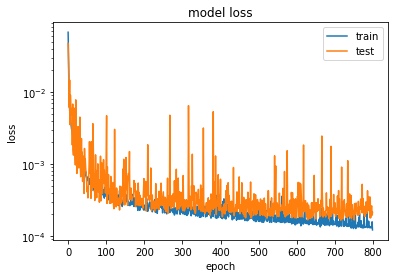

In [91]:
train_plot(history)

In [92]:
evaluate_model(model, eval_set, n, m, batch_size=32)

339/339 [==============================] - 0s 93us/step


0.00016576771855843323

In [93]:
math.sqrt(evaluate_model(model, eval_set, n, m, batch_size=32))

339/339 [==============================] - 0s 78us/step


0.01287508130298342

In [94]:
math.sqrt(evaluate_model(model, eval_set, n, m, batch_size=32)) * capacity

339/339 [==============================] - 0s 67us/step


7.428921911821433

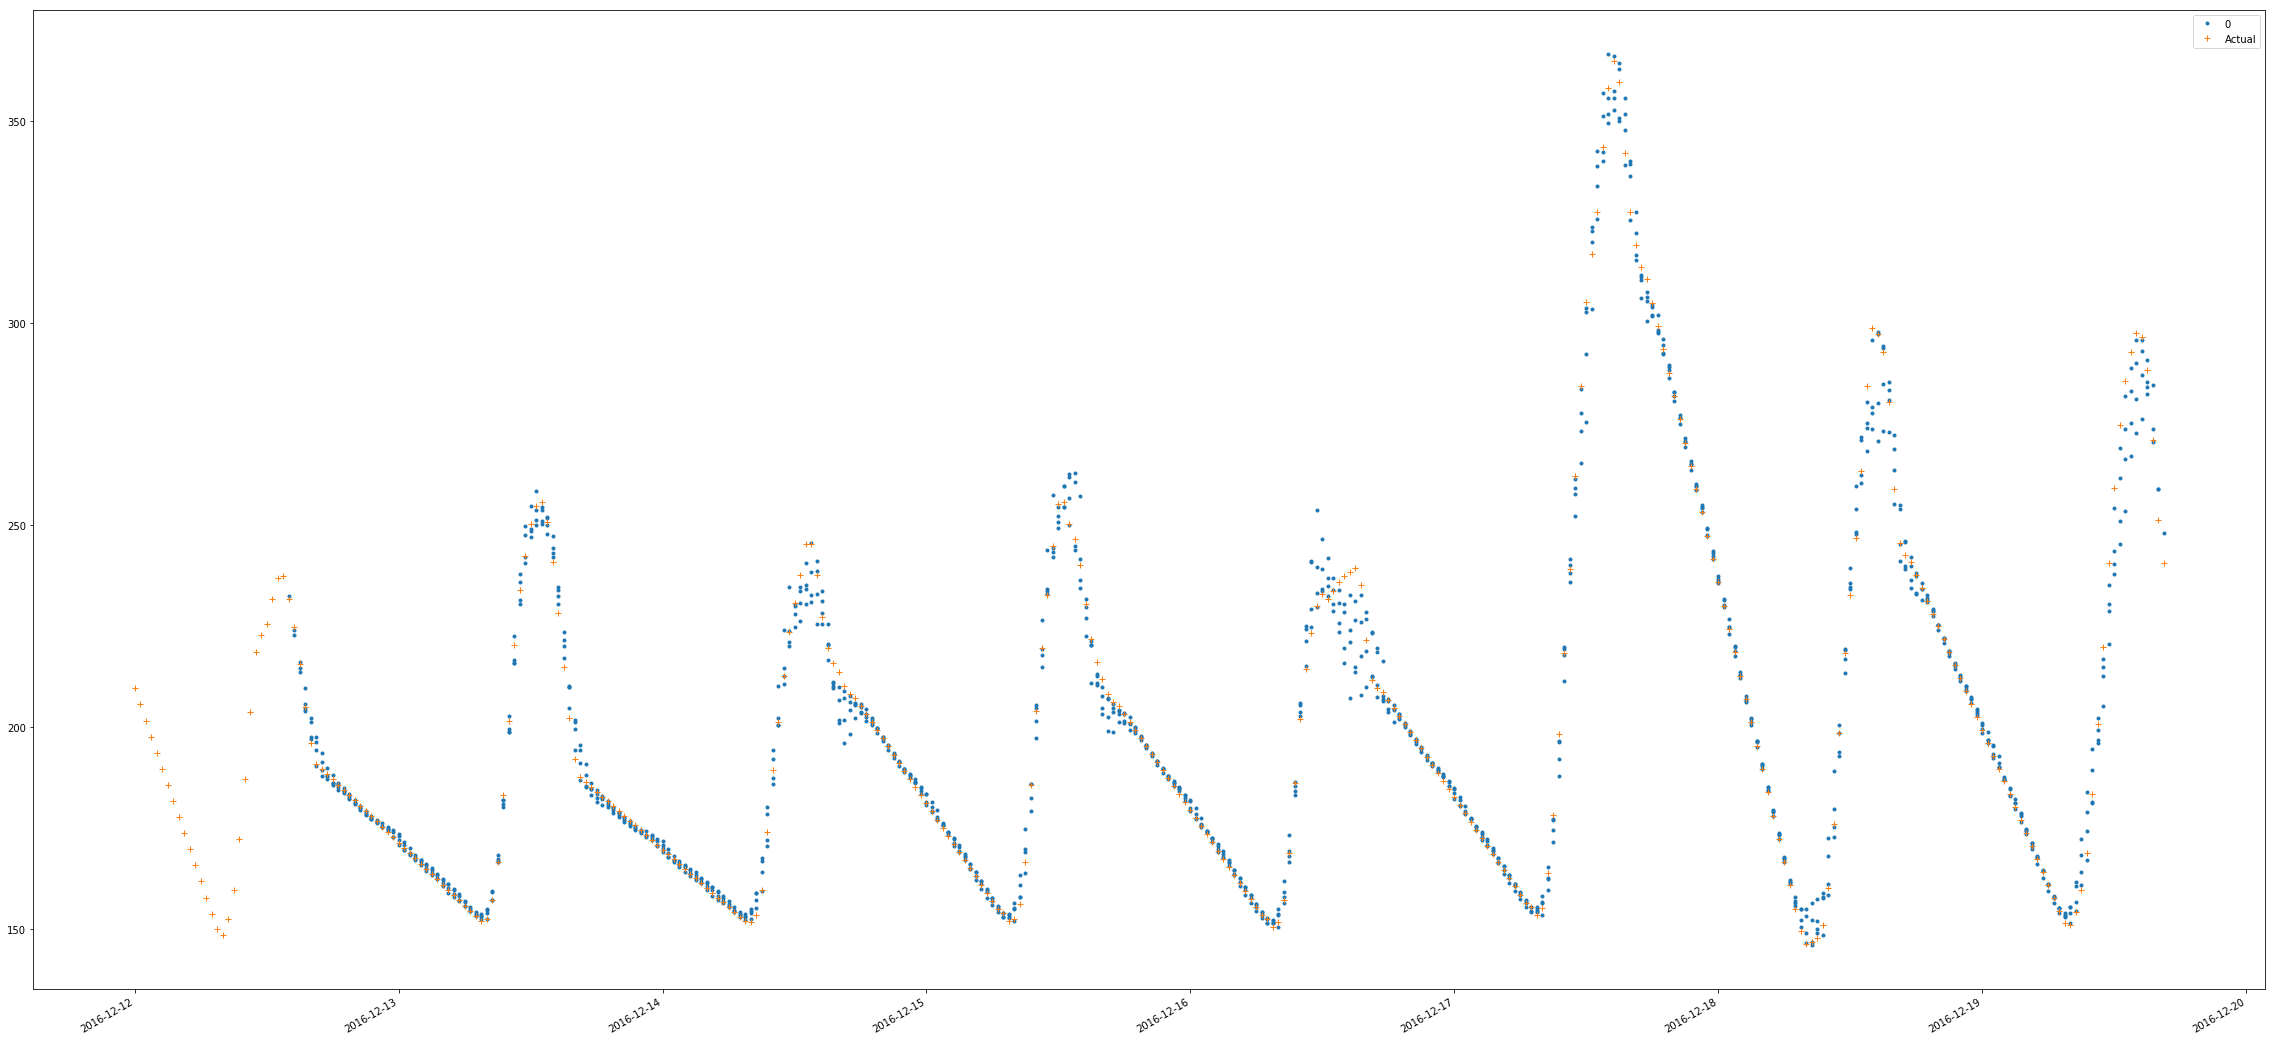

In [95]:
evaluate_model_plot(model, eval_set, n, m, lambda x: ((x + 1.0) / 2.0) * capacity)

## LESS Units?

In [96]:
%%time
data = dataset['BHMBCCMKT01']
n, m = 12, 4  # Predict 2 hour ahead using 6 hours worth of past data
train_set, eval_set, capacity = split_by_week(data, validation_size=2)
model, history = train_model(train_set, eval_set, n, m,
                    num_lstm_layers=1,
                    hidden_size=20,
                    batch_size=32,
                    epochs=800)
model, history

Train on 3282 samples, validate on 355 samples
Epoch 1/800
3282/3282 [==============================] - 3s 1ms/step - loss: 0.0851 - val_loss: 0.0557
Epoch 2/800
3282/3282 [==============================] - 1s 154us/step - loss: 0.0446 - val_loss: 0.0350
Epoch 3/800
3282/3282 [==============================] - 1s 165us/step - loss: 0.0286 - val_loss: 0.0226
Epoch 4/800
3282/3282 [==============================] - 1s 160us/step - loss: 0.0206 - val_loss: 0.0173
Epoch 5/800
3282/3282 [==============================] - 0s 145us/step - loss: 0.0141 - val_loss: 0.0133
Epoch 6/800
3282/3282 [==============================] - 0s 145us/step - loss: 0.0108 - val_loss: 0.0099
Epoch 7/800
3282/3282 [==============================] - 1s 152us/step - loss: 0.0093 - val_loss: 0.0085
Epoch 8/800
3282/3282 [==============================] - 0s 137us/step - loss: 0.0082 - val_loss: 0.0073
Epoch 9/800
3282/3282 [==============================] - 0s 147us/step - loss: 0.0072 - val_loss: 0.0075
Epoch 10/8

Epoch 148/800
3282/3282 [==============================] - 0s 143us/step - loss: 4.7125e-04 - val_loss: 3.3586e-04
Epoch 149/800
3282/3282 [==============================] - 0s 138us/step - loss: 5.8550e-04 - val_loss: 5.9921e-04
Epoch 150/800
3282/3282 [==============================] - 0s 146us/step - loss: 5.4558e-04 - val_loss: 3.3392e-04
Epoch 151/800
3282/3282 [==============================] - 0s 147us/step - loss: 4.9888e-04 - val_loss: 3.8120e-04
Epoch 152/800
3282/3282 [==============================] - 0s 145us/step - loss: 5.6089e-04 - val_loss: 3.3960e-04
Epoch 153/800
3282/3282 [==============================] - 0s 149us/step - loss: 4.4651e-04 - val_loss: 0.0013
Epoch 154/800
3282/3282 [==============================] - 0s 149us/step - loss: 5.0465e-04 - val_loss: 3.3018e-04
Epoch 155/800
3282/3282 [==============================] - 0s 149us/step - loss: 4.4965e-04 - val_loss: 3.9910e-04
Epoch 156/800
3282/3282 [==============================] - 0s 140us/step - loss: 4.5

3282/3282 [==============================] - 0s 150us/step - loss: 3.4524e-04 - val_loss: 3.2497e-04
Epoch 291/800
3282/3282 [==============================] - 0s 152us/step - loss: 3.5797e-04 - val_loss: 3.1585e-04
Epoch 292/800
3282/3282 [==============================] - 0s 149us/step - loss: 3.0606e-04 - val_loss: 2.9831e-04
Epoch 293/800
3282/3282 [==============================] - 0s 149us/step - loss: 3.4607e-04 - val_loss: 3.5010e-04
Epoch 294/800
3282/3282 [==============================] - 0s 146us/step - loss: 4.2918e-04 - val_loss: 4.3327e-04
Epoch 295/800
3282/3282 [==============================] - 0s 147us/step - loss: 3.0964e-04 - val_loss: 3.9712e-04
Epoch 296/800
3282/3282 [==============================] - 0s 149us/step - loss: 3.1454e-04 - val_loss: 0.0030
Epoch 297/800
3282/3282 [==============================] - 0s 151us/step - loss: 3.5483e-04 - val_loss: 2.8213e-04
Epoch 298/800
3282/3282 [==============================] - 0s 147us/step - loss: 3.5494e-04 - val_

3282/3282 [==============================] - 0s 143us/step - loss: 2.5883e-04 - val_loss: 3.1523e-04
Epoch 433/800
3282/3282 [==============================] - 0s 142us/step - loss: 2.7703e-04 - val_loss: 2.7907e-04
Epoch 434/800
3282/3282 [==============================] - 1s 153us/step - loss: 2.7810e-04 - val_loss: 3.3128e-04
Epoch 435/800
3282/3282 [==============================] - 0s 149us/step - loss: 3.4462e-04 - val_loss: 3.2342e-04
Epoch 436/800
3282/3282 [==============================] - 1s 154us/step - loss: 3.1763e-04 - val_loss: 2.6585e-04
Epoch 437/800
3282/3282 [==============================] - 1s 156us/step - loss: 2.9494e-04 - val_loss: 2.5100e-04
Epoch 438/800
3282/3282 [==============================] - 0s 142us/step - loss: 2.6074e-04 - val_loss: 2.3907e-04
Epoch 439/800
3282/3282 [==============================] - 0s 145us/step - loss: 3.2524e-04 - val_loss: 2.3782e-04
Epoch 440/800
3282/3282 [==============================] - 0s 134us/step - loss: 3.1096e-04 - 

3282/3282 [==============================] - 0s 149us/step - loss: 2.7949e-04 - val_loss: 2.5250e-04
Epoch 575/800
3282/3282 [==============================] - 0s 146us/step - loss: 2.7257e-04 - val_loss: 2.3387e-04
Epoch 576/800
3282/3282 [==============================] - 1s 153us/step - loss: 2.3764e-04 - val_loss: 3.2213e-04
Epoch 577/800
3282/3282 [==============================] - 0s 149us/step - loss: 2.8944e-04 - val_loss: 3.1401e-04
Epoch 578/800
3282/3282 [==============================] - 0s 146us/step - loss: 2.3876e-04 - val_loss: 2.8331e-04
Epoch 579/800
3282/3282 [==============================] - 0s 146us/step - loss: 2.5011e-04 - val_loss: 2.7639e-04
Epoch 580/800
3282/3282 [==============================] - 0s 148us/step - loss: 2.7785e-04 - val_loss: 2.3957e-04
Epoch 581/800
3282/3282 [==============================] - 0s 147us/step - loss: 2.4913e-04 - val_loss: 2.5786e-04
Epoch 582/800
3282/3282 [==============================] - 0s 146us/step - loss: 2.6300e-04 - 

3282/3282 [==============================] - 0s 149us/step - loss: 2.5209e-04 - val_loss: 2.3367e-04
Epoch 717/800
3282/3282 [==============================] - 0s 147us/step - loss: 2.5247e-04 - val_loss: 2.3017e-04
Epoch 718/800
3282/3282 [==============================] - 0s 150us/step - loss: 2.7098e-04 - val_loss: 2.9244e-04
Epoch 719/800
3282/3282 [==============================] - 0s 147us/step - loss: 2.2823e-04 - val_loss: 3.1899e-04
Epoch 720/800
3282/3282 [==============================] - 1s 152us/step - loss: 2.6632e-04 - val_loss: 2.1547e-04
Epoch 721/800
3282/3282 [==============================] - 0s 150us/step - loss: 2.3255e-04 - val_loss: 2.0761e-04
Epoch 722/800
3282/3282 [==============================] - 0s 147us/step - loss: 2.2414e-04 - val_loss: 2.3724e-04
Epoch 723/800
3282/3282 [==============================] - 0s 142us/step - loss: 2.4497e-04 - val_loss: 2.2811e-04
Epoch 724/800
3282/3282 [==============================] - 0s 146us/step - loss: 2.6430e-04 - 

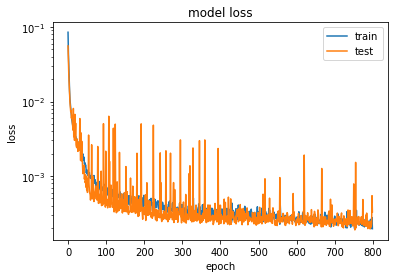

In [97]:
train_plot(history)

In [98]:
evaluate_model(model, eval_set, n, m, batch_size=32)

355/355 [==============================] - 0s 92us/step


0.00018888108774980293

In [99]:
math.sqrt(evaluate_model(model, eval_set, n, m, batch_size=32))

355/355 [==============================] - 0s 64us/step


0.013743401607673515

In [100]:
math.sqrt(evaluate_model(model, eval_set, n, m, batch_size=32)) * capacity

355/355 [==============================] - 0s 72us/step


7.929942727627618

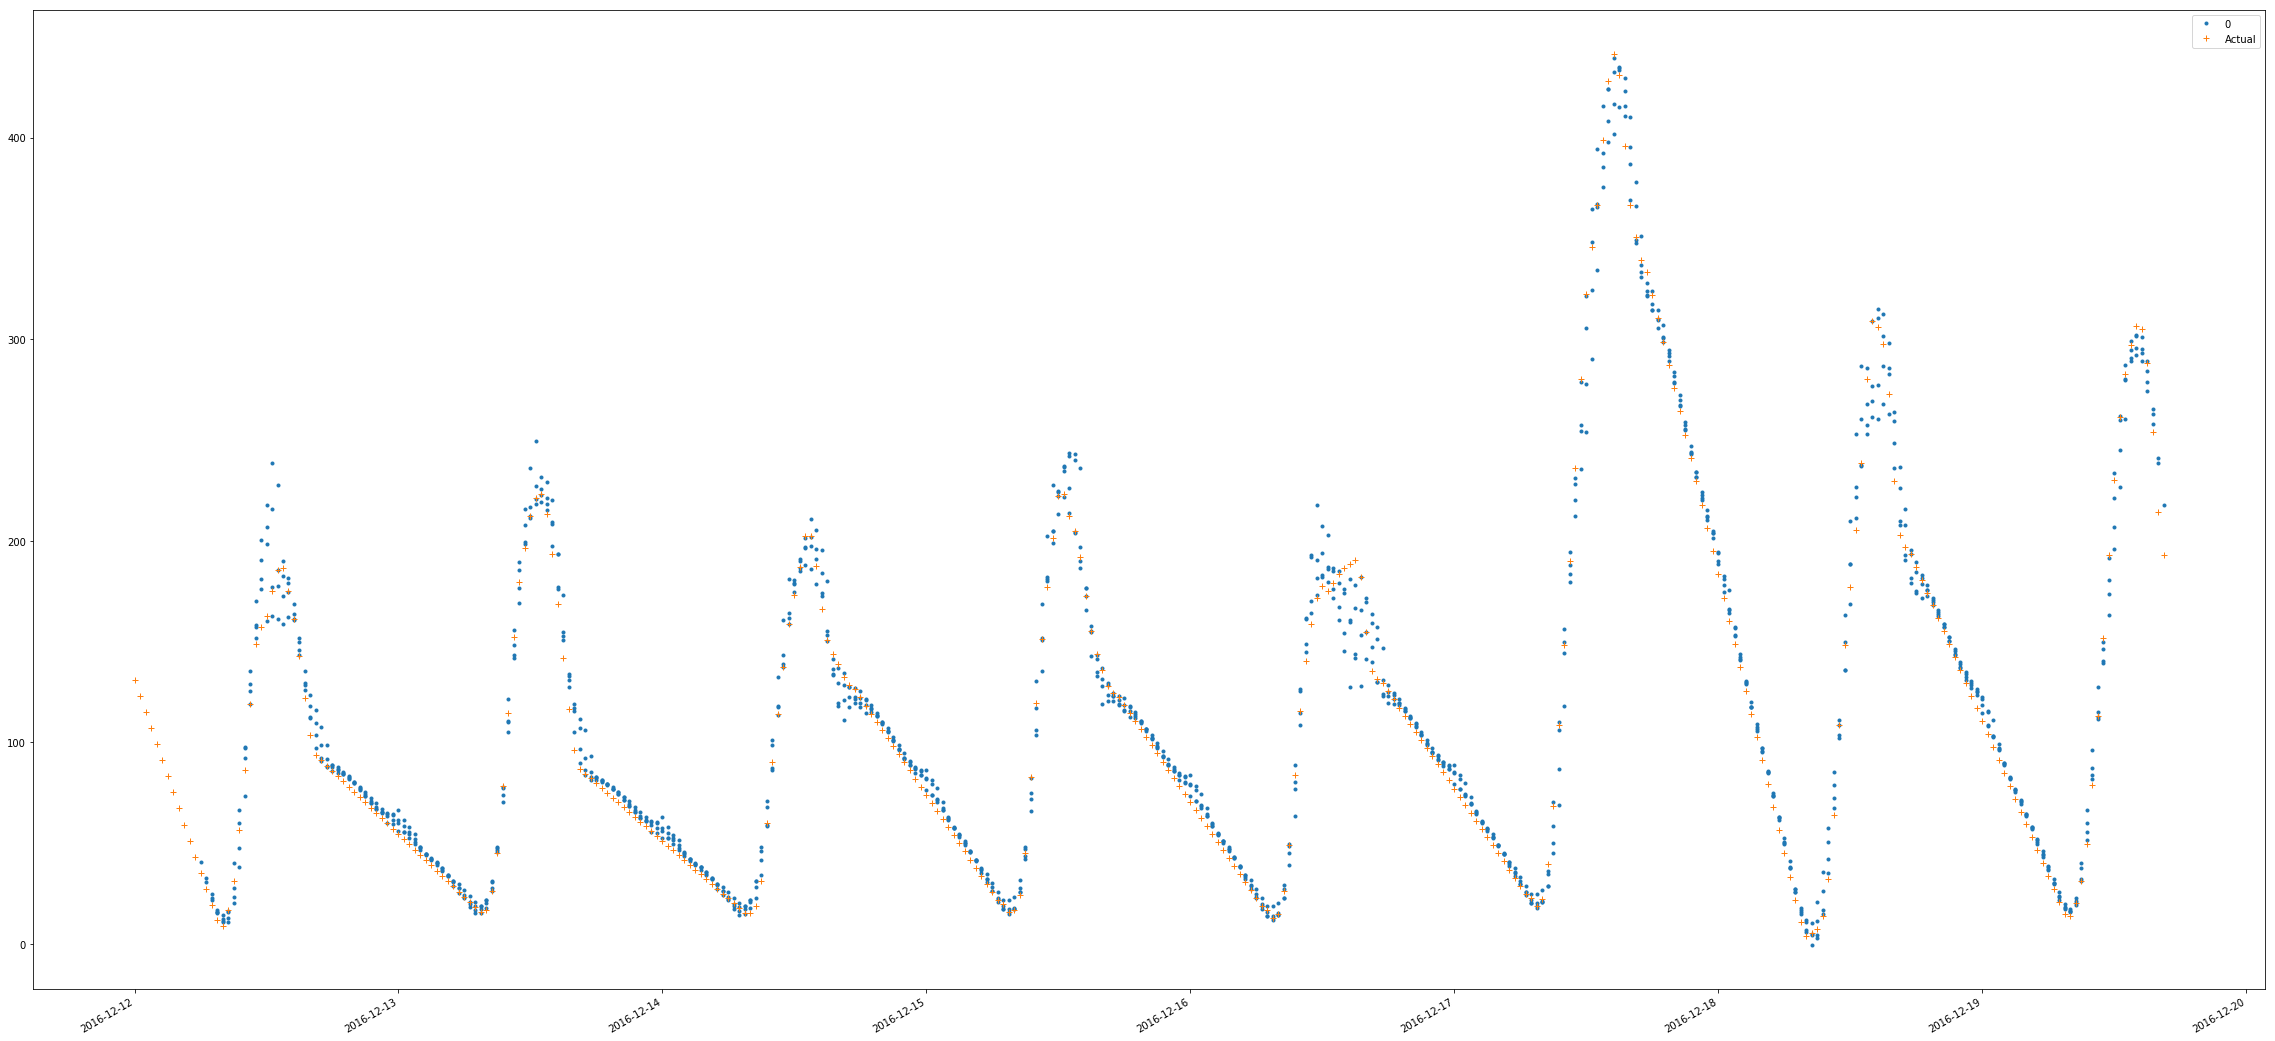

In [102]:
evaluate_model_plot(model, eval_set, n, m, lambda x: (x + 0.5) * capacity)